Preguntas extra y mejoradas hito 1 para poder aplicar herramientas y no solo EDA (exploratory data analysis)





In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [35]:
df_cc = pd.read_csv('credit_card_transactions-ibm_v2.csv')
df_users = pd.read_csv('sd254_users.csv')
df_cards = pd.read_csv('sd254_cards.csv')
df_usercc = pd.read_csv("User0_credit_card_transactions.csv")
df_users["User"] = range(0, len(df_users)) # Crear columna User en df_users para index

In [37]:
#Limpieza de datos
df_cc['Amount'] = df_cc['Amount'].str.replace('$', '').astype(float) #dolares a float
df_cc['Hour'] = df_cc['Time'].str.split(':').str[0].astype(int)   #hora:min a hora int
df_cc.drop(columns=['Time'], inplace=True)
df_cc['Is Fraud?'] = df_cc["Is Fraud?"].map({"No": False, "Yes": True})
df_gigante = df_cc.merge(df_users, how="inner", on="User")   #merge de df_cc y df_users

Se calcularán relación entre transacciones fraudulentas y la cantidad de dinero inovlucrada

In [39]:
#Series(string(?)) a float la columna Amount
# cambiar la columna Is Fraud? a booleano
#y dejar solo las columnas Amount y Is Fraud?
#también se ordena por Amount
df_cc_sorted = df_cc[['Amount', 'Is Fraud?']].sort_values(by='Amount').copy().reset_index(drop=True)

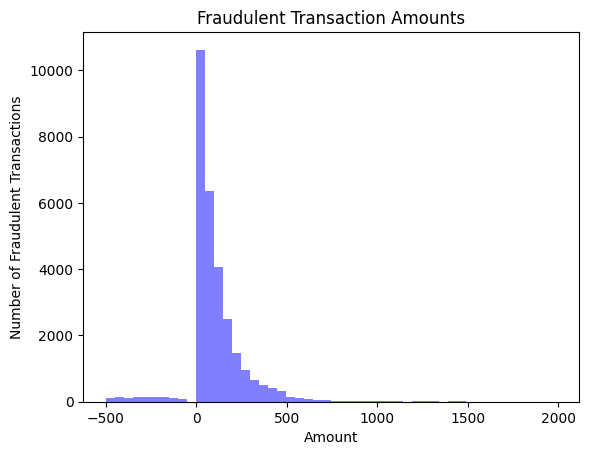

In [40]:
#solo se dejan fraudulentas
df_frauds = df_cc_sorted[df_cc_sorted['Is Fraud?'] == True]
#se filtran menores a2000
df_frauds.loc[:, 'Amount'] = df_frauds[df_frauds['Amount'] < 2000]

#se grafica
plt.hist(df_frauds['Amount'], bins=50, color='blue', alpha=0.5)
plt.title('Distribution of Fraudulent Transaction Amounts')
plt.xlabel('Amount')
plt.ylabel('Number of Fraudulent Transactions')

plt.title('Fraudulent Transaction Amounts')
plt.show()

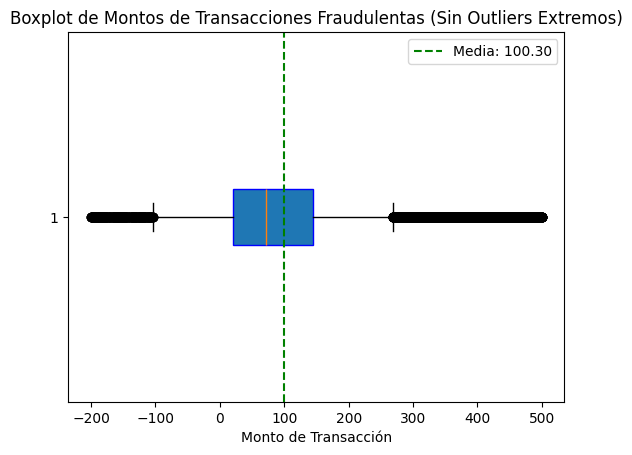

In [41]:
# Filtrar datos dentro de un rango de interés para reducir outliers visibles
filtered_data = df_frauds[(df_frauds['Amount'] >= -200) & (df_frauds['Amount'] <= 500)]

# Crear el boxplot con límites y opciones ajustadas
plt.boxplot(filtered_data['Amount'], vert=False, patch_artist=True, whis=1.0, boxprops=dict(color="blue"))

# Etiquetas y título
plt.xlabel('Monto de Transacción')
plt.title('Boxplot de Montos de Transacciones Fraudulentas (Sin Outliers Extremos)')

# Agregar línea para la media
mean_value = filtered_data['Amount'].mean()
plt.axvline(mean_value, color='green', linestyle='--', label=f'Media: {mean_value:.2f}')
plt.legend()
plt.show()


Se obtiene que los fraudes predominan en rangos pequeños de dinero

Ahora se analizará si es más probable según día del mes, día de la semana, horario

In [42]:
df_cc_times = df_cc.copy()
df_frauds = df_cc_times[df_cc_times['Is Fraud?'] == True]
df_frauds_times = df_frauds[['Year', 'Month', 'Day', 'Hour', 'Is Fraud?']].copy()  #Tabla con fechas de fraudes

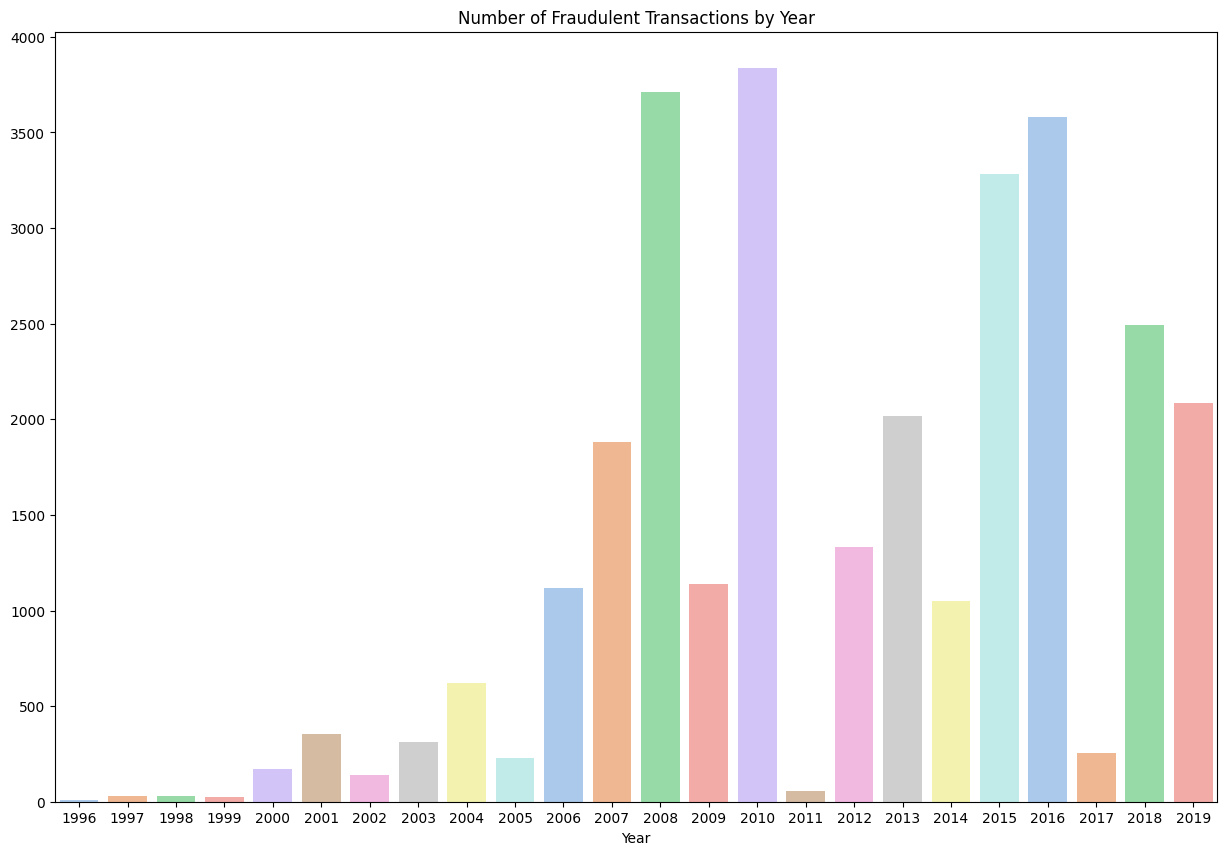

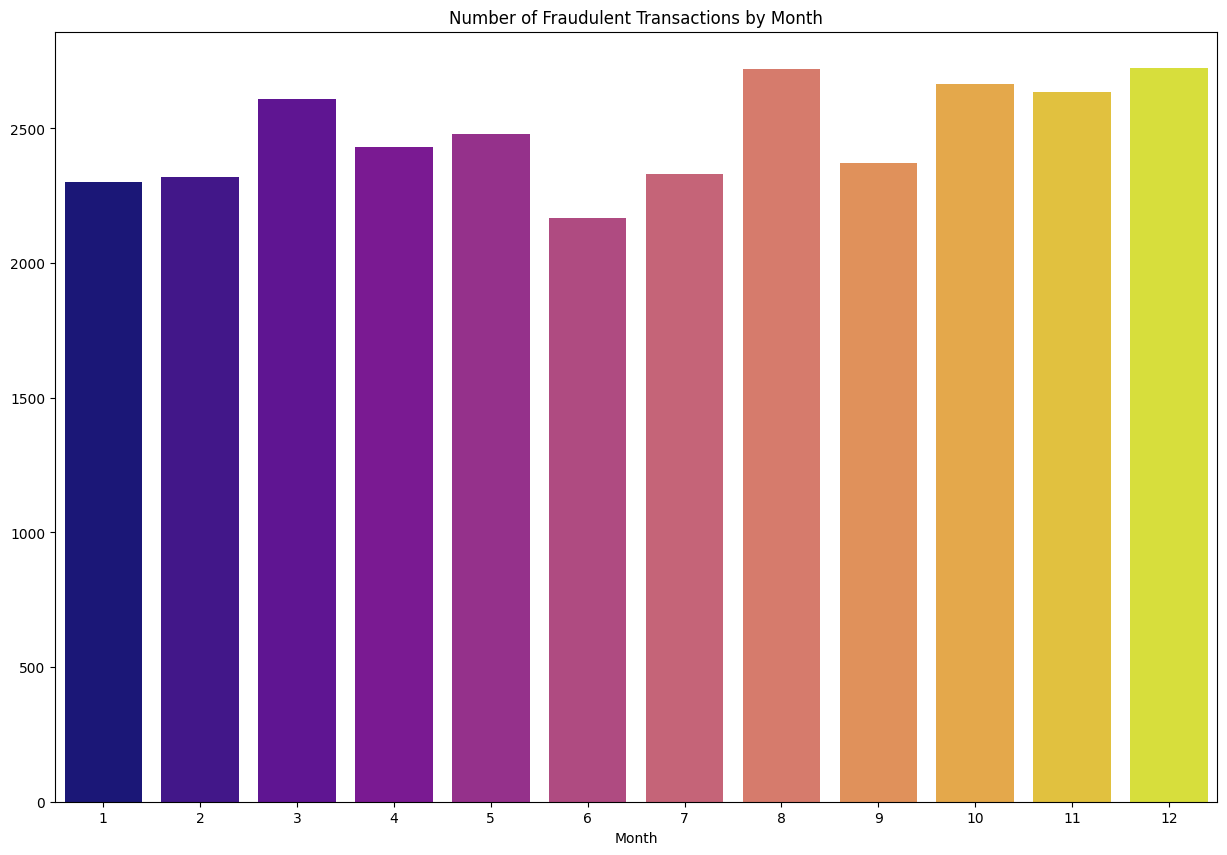

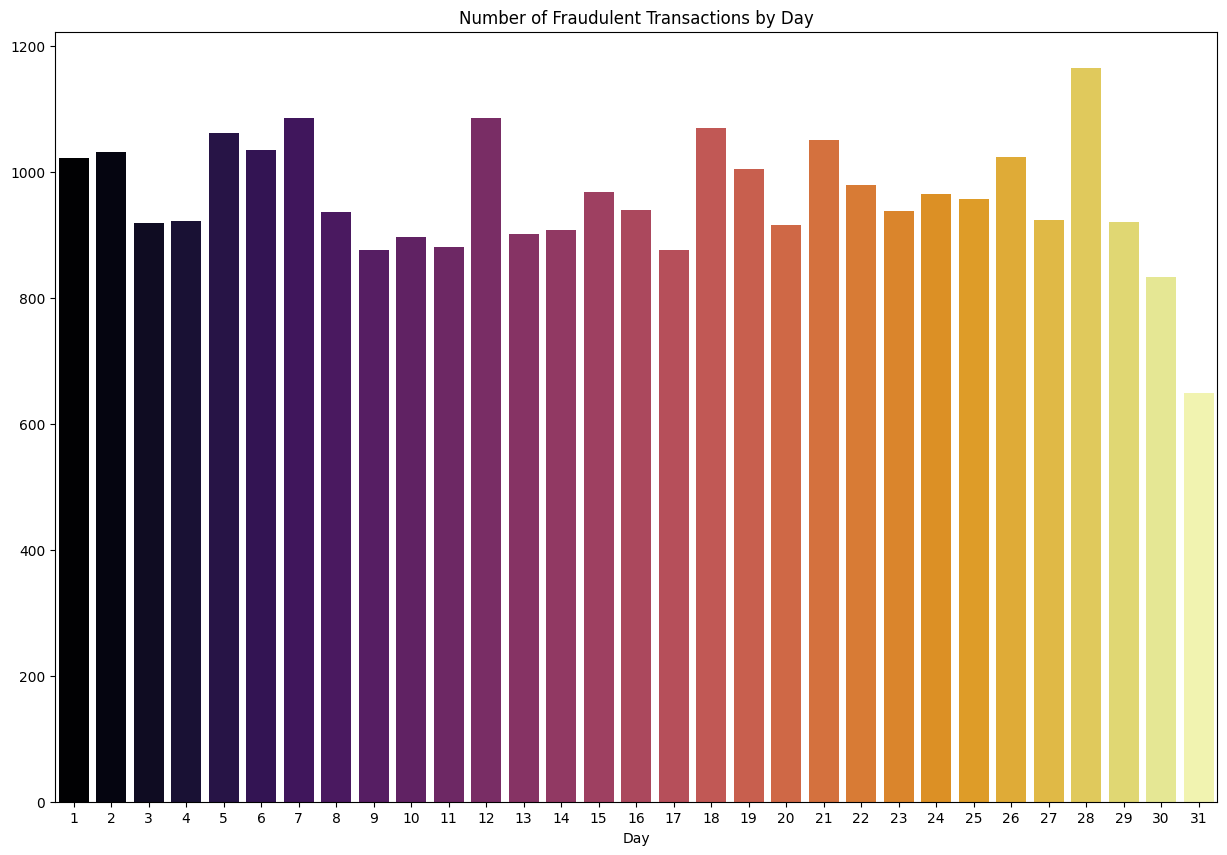

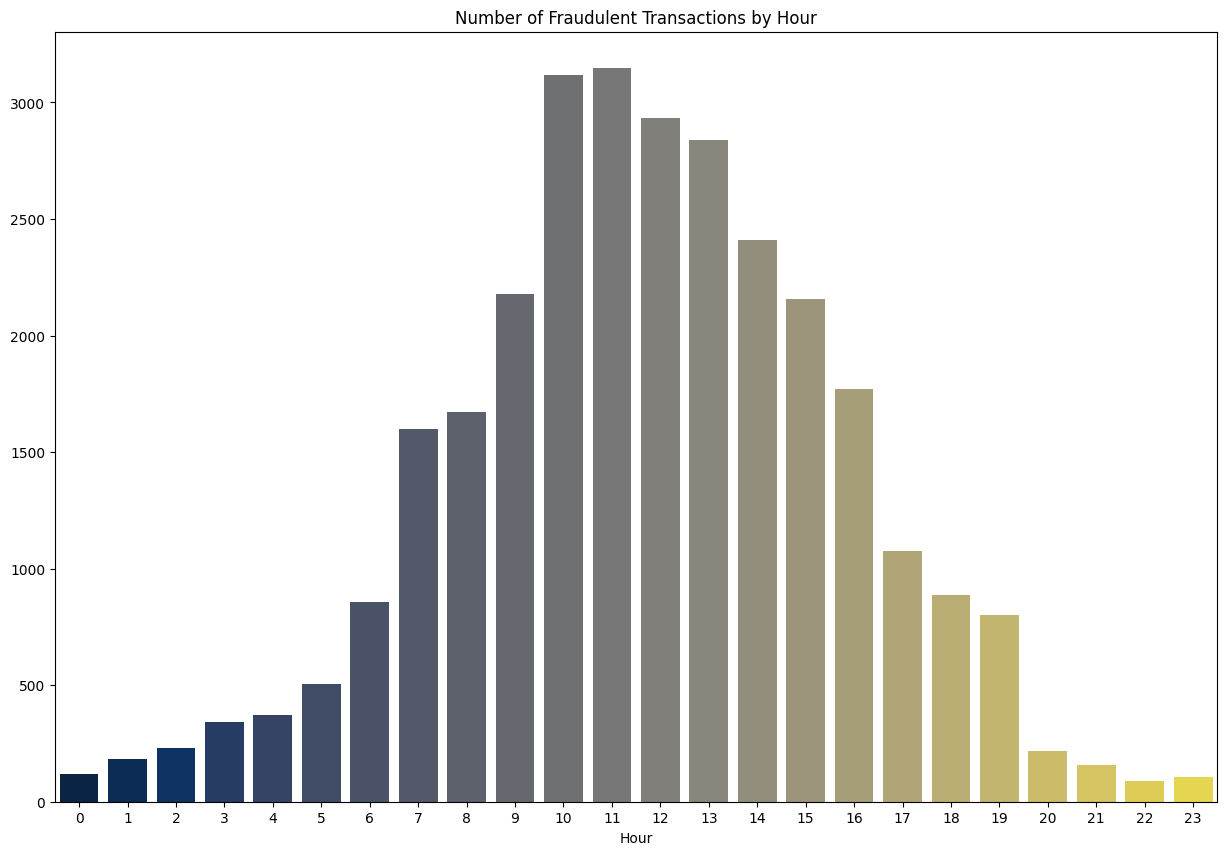

In [43]:
plt.figure(figsize=(15, 10))
sns.countplot(data=df_frauds_times, x='Year', hue='Year', palette='pastel', legend=False)
plt.title('Number of Fraudulent Transactions by Year')
plt.legend([],[], frameon=False)  # Ocultar la leyenda
plt.ylabel('') # Ocultar el nombre del eje y
plt.show()

plt.figure(figsize=(15, 10))
sns.countplot(data=df_frauds_times, x='Month', hue='Month', palette='plasma', legend=False)
plt.title('Number of Fraudulent Transactions by Month')
plt.legend([],[], frameon=False)  # Ocultar la leyenda
plt.ylabel('') # Ocultar el nombre del eje y
plt.show()

plt.figure(figsize=(15, 10))
sns.countplot(data=df_frauds_times, x='Day', hue='Day', palette='inferno', legend=False)
plt.title('Number of Fraudulent Transactions by Day')
plt.legend([],[], frameon=False)  # Ocultar la leyenda
plt.ylabel('') # Ocultar el nombre del eje y
plt.show()

plt.figure(figsize=(15, 10))
sns.countplot(data=df_frauds_times, x='Hour', hue='Hour', palette='cividis', legend=False)
plt.title('Number of Fraudulent Transactions by Hour')
plt.legend([],[], frameon=False)  # Ocultar la leyenda
plt.ylabel('') # Ocultar el nombre del eje y
plt.show()

Se observa que la hora del día y el año influyen en la cantidad de fraudes

Finalmente se estudiará si el lugar de la transferencia influye en los fraudes

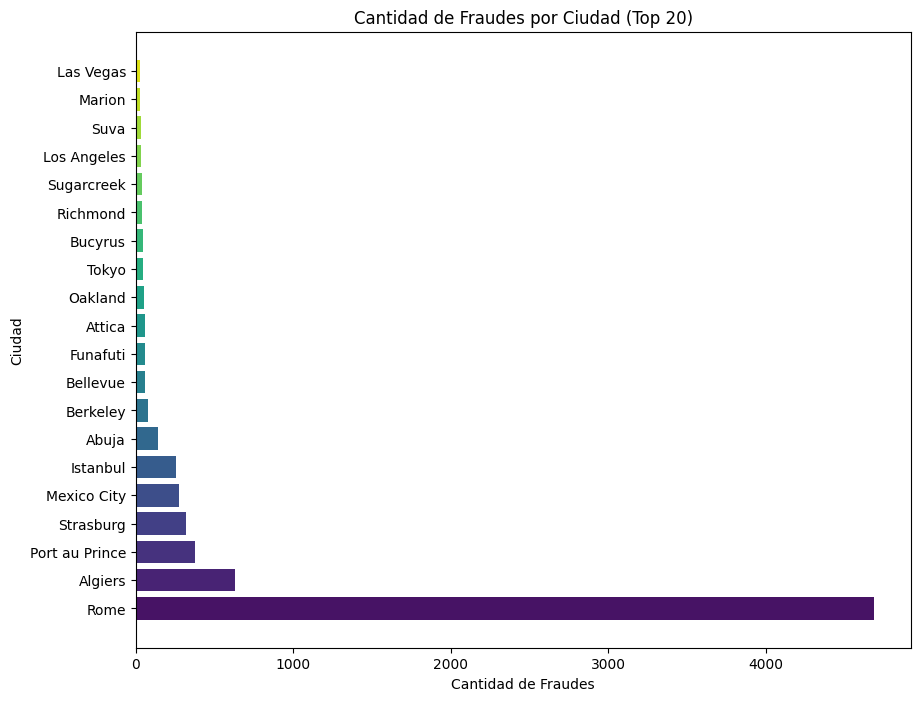

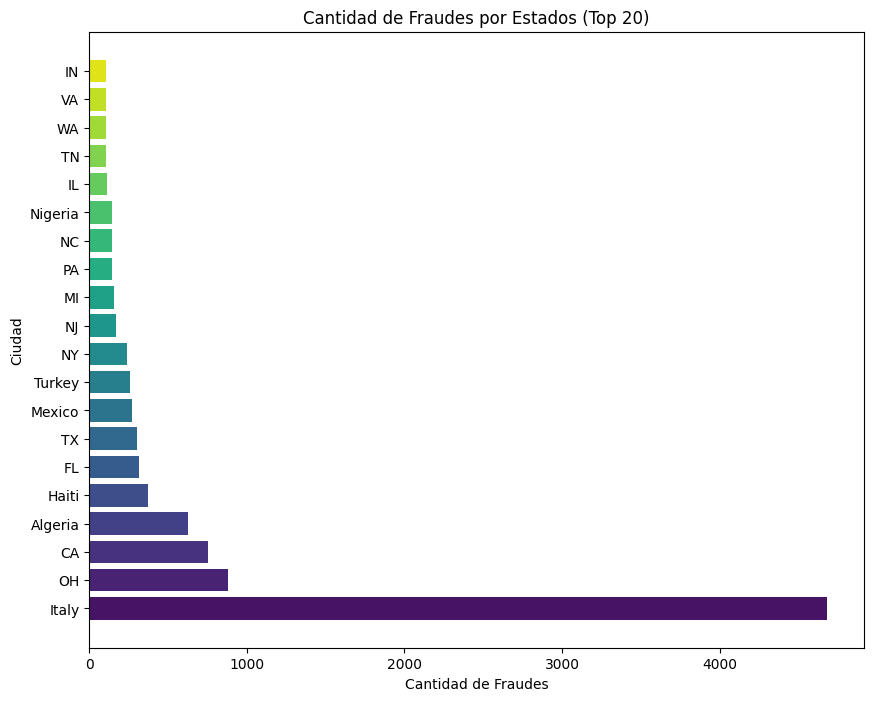

In [44]:
df_ciudades_frauds = df_frauds.groupby('Merchant City')['Is Fraud?'].sum().sort_values(ascending=False)

df_ciudades_frauds = df_ciudades_frauds.iloc[1:]  # Eliminar Online

top_20_ciudades = df_ciudades_frauds.head(20)

plt.figure(figsize=(10, 8))
bars = plt.barh(top_20_ciudades.index, top_20_ciudades.values, color=sns.color_palette('viridis', 20))
plt.xlabel('Cantidad de Fraudes')
plt.ylabel('Ciudad')
plt.title('Cantidad de Fraudes por Ciudad (Top 20)')

plt.show()

df_estados_frauds = df_frauds.groupby('Merchant State')['Is Fraud?'].sum().sort_values(ascending=False)

top_20_estados = df_estados_frauds.head(20)

plt.figure(figsize=(10, 8))
bars = plt.barh(top_20_estados.index, top_20_estados.values, color=sns.color_palette('viridis', 20))
plt.xlabel('Cantidad de Fraudes')
plt.ylabel('Ciudad')
plt.title('Cantidad de Fraudes por Estados (Top 20)')

plt.show()




Sí, se ve una correlación entre fraudes y ciudades/estados

Veremos si hacer transacciones extranjero (lugar fuera ciudad/estado del que el usuario vive)

In [10]:
df_user_location = df_gigante[['User', 'Merchant City', 'Merchant State', 'City', 'State', 'Is Fraud?']]

C:\Users\aleja\AppData\Local\Temp\ipykernel_48652\1044937831.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_user_location.loc[:, 'Is Foreign?'] = df_user_location['Merchant State'] != df_user_location['State']


Is Foreign?
False    0.018923
True     0.533362
Name: Is Fraud?, dtype: float64


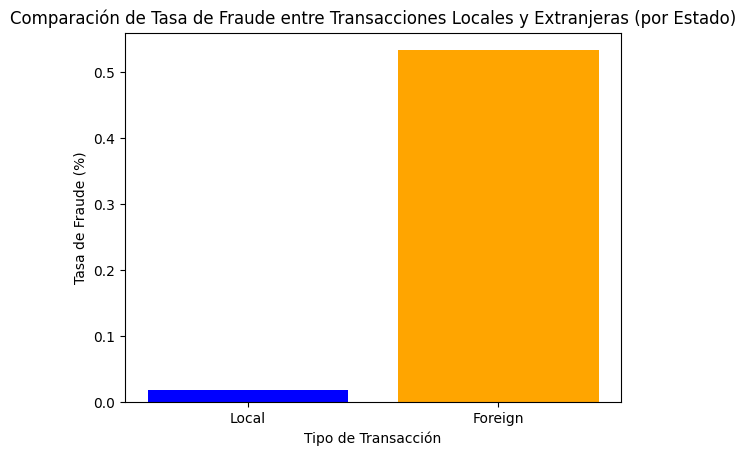

In [11]:
df_user_location.loc[:, 'Is Foreign?'] = df_user_location['Merchant State'] != df_user_location['State']

#Se calculará la tasa de fraude
foreign_fraud_rate = df_user_location.groupby('Is Foreign?')['Is Fraud?'].mean() * 100
print(foreign_fraud_rate)

# Crear el gráfico de barras
plt.bar(['Local', 'Foreign'], foreign_fraud_rate, color=['blue', 'orange'])
plt.xlabel('Tipo de Transacción')
plt.ylabel('Tasa de Fraude (%)')
plt.title('Comparación de Tasa de Fraude entre Transacciones Locales y Extranjeras (por Estado)')
plt.show()

Ahora se anazizará que caracteristicas de la tarjeta tiene relación con los fraudes

In [46]:
df_cards_chikita = df_cards[['User', 'CARD INDEX', 'Year PIN last Changed', 'Card on Dark Web', 'Has Chip']].copy()
df_cards_chikita['Card on Dark Web'] = df_cards_chikita['Card on Dark Web'].map({"No": False, "Yes": True})
df_cards_chikita['Has Chip'] = df_cards_chikita['Has Chip'].map({"NO": False, "YES": True})


df_cc_chikito = df_cc[['User', 'Card', 'Year', 'Is Fraud?']]

df_cc_cards = df_cc_chikito.merge(df_cards_chikita, how='inner', left_on=['User', 'Card'], right_on=['User', 'CARD INDEX'])

In [47]:
# Número total de fraudes
df_frauds = df_cc_cards[df_cc_cards['Is Fraud?'] == True]
total_fraudes = df_frauds.shape[0]

# Número de fraudes con tarjetas en dark web y sin dark web
fraudes_darkweb = df_frauds[df_frauds['Card on Dark Web'] == True].shape[0]
fraudes_no_darkweb = df_frauds[df_frauds['Card on Dark Web'] == False].shape[0]

print(f'Número total de fraudes: {total_fraudes}')
print(f'Número de fraudes con tarjetas en dark web: {fraudes_darkweb}')
print(f'Número de fraudes con tarjetas no en dark web: {fraudes_no_darkweb}')


Número total de fraudes: 29757
Número de fraudes con tarjetas en dark web: 0
Número de fraudes con tarjetas no en dark web: 29757


Se observa que no hay tarjetas en la dark web que tengan fraude, así que no tiene relación

Por último si tener chip en la tarjeta afecta

Has Chip
False    0.113095
True     0.123029
Name: Is Fraud?, dtype: float64


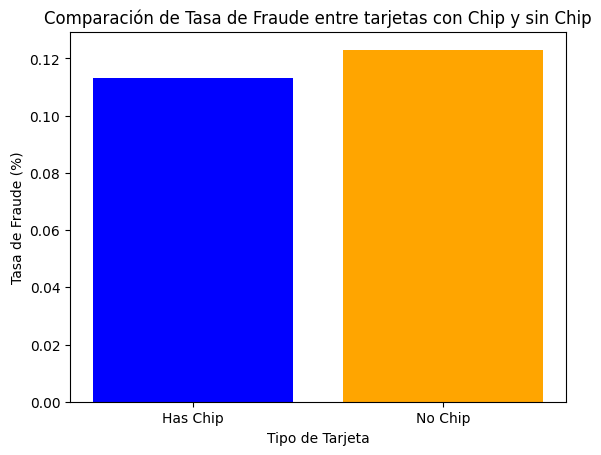

In [48]:
# Calcular la tasa de fraude para tarjetas con chip y sin chip
fraud_rate_chip = df_cc_cards.groupby('Has Chip')['Is Fraud?'].mean() * 100

# Mostrar la tasa de fraude para cada tipo de tarjeta
print(fraud_rate_chip)

# Crear el gráfico de barras
plt.bar(['Has Chip', 'No Chip'], fraud_rate_chip, color=['blue', 'orange'])
plt.xlabel('Tipo de Tarjeta')
plt.ylabel('Tasa de Fraude (%)')
plt.title('Comparación de Tasa de Fraude entre tarjetas con Chip y sin Chip')
plt.show()

No afecta.

Nuevas preguntas enfocadas a lo que se ha aprendido en el curso de mineria


-¿Cómo impacta el balance de clases en la precisión de los modelos de predicción de fraude?” (ahí usamos los scores)

-¿Qué combinaciones de características están más asociadas con transacciones fraudulentas?

gpt m dijo: 

 - **Método**: Reglas de asociación
 
 - **Descripción**: Usa algoritmos de minería de datos como el Apriori o FP-Growth para identificar patrones frecuentes de características en las transacciones fraudulentas. Podrías buscar combinaciones como:
Rango de montos + Edad del usuario + Hora del día
Estado/ciudad de transacción + Extranjero o no + Año
 
 - **Objetivo:** Identificar combinaciones de características que ocurren frecuentemente en transacciones fraudulentas. Esto podría darte información sobre qué factores tienden a aparecer juntos en casos de fraude.
 
 - **Ejemplo:** Puedes encontrar reglas como "si la transacción es en un estado diferente al de residencia y ocurre durante la noche, entonces es más probable que sea fraude".
 


-¿Cómo afecta el balanceo de datos en el rendimiento de los modelos predictivos de fraude?
 
 - Descripción: Puedes comparar el rendimiento de modelos entrenados con los datos originales y con datos balanceados (utilizando técnicas como SMOTE o undersampling). Esto te permitirá observar si balancear los datos mejora la capacidad del modelo para identificar fraudes.
 
 - Método: Entrena varios modelos (como árboles de decisión, Random Forest, o redes neuronales) con y sin técnicas de balanceo. Evalúa el rendimiento con métricas como precisión, recall, y F1.
 
 - Objetivo: Verificar si el balanceo de datos ayuda al modelo a mejorar la identificación de fraudes y reducir los falsos negativos.


-“¿Cuál es la tasa óptima de balance entre fraudes y no fraudes para maximizar la precisión sin aumentar los falsos positivos?”

 - Descripción: Esta pregunta busca identificar el punto óptimo de balance para tu dataset. En lugar de hacer un balance perfecto (igual número de fraudes y no fraudes), puedes probar con diferentes niveles de balanceo (por ejemplo, 10% fraudes, 20% fraudes) y ver cuál ofrece el mejor rendimiento en términos de precisión y recall.
 
 - Método: Crea versiones del dataset con diferentes niveles de balance y entrena un modelo en cada versión. Observa cómo varían las métricas a medida que cambias el balance.
 
 - Objetivo: Encontrar el balance óptimo que maximice la identificación de fraudes sin comprometer demasiado el número de falsos positivos.



-“¿Qué características contribuyen más a la separación entre transacciones fraudulentas y no fraudulentas?”
 
 - Objetivo: Al observar la distancia entre clusters de fraude y no fraude, puedes identificar las características que generan esta separación. Por ejemplo, si al usar ciertas variables encuentras una buena separación entre fraudes y no fraudes, eso indica que esas características son útiles para diferenciar las dos clases.
 
 - Resultado Esperado: Con métricas como la distancia entre centroides o el índice de silueta, puedes medir el poder de separación de las características. Esto te ayuda a saber qué características son más importantes y podrían ser útiles en un modelo de clasificación supervisada en el futuro.


Las features que más afectan q obtuvimos en el EDA son

Si fue online, Amount, Edad usuario, el año y la hora del día que se hace la transacción, el estado y ciudad, si es que la transacción se hizo en el extranjero.     